In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', None)

In [2]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 14.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


In [4]:
df_census = pd.read_csv('census_data.csv', header=1)

df_census_clean = df_census[
    ['Geographic Area Name',
     'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',
     'Estimate!!INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)']
]

df_census_clean.columns = ['County_State', 'Unemployment_Rate', 'Median_Income']

df_census_clean[['County', 'State']] = df_census_clean['County_State'].str.split(', ', expand=True)

df_census_clean['Median_Income'] = pd.to_numeric(df_census_clean['Median_Income'], errors='coerce')
df_census_clean['Unemployment_Rate'] = pd.to_numeric(df_census_clean['Unemployment_Rate'], errors='coerce')

df_census_clean.dropna(inplace=True)

df_census_clean['County'] = df_census_clean['County'].str.replace(' County', '').str.title().str.strip()
df_census_clean['State'] = df_census_clean['State'].str.title().str.strip()

df_census_clean.head()

/var/folders/pq/fk5prhgs73qf187t_d7qcfhc0000gn/T/ipykernel_56415/2452198656.py:1: DtypeWarning: Columns (50,51,124,125,138,139,172,173,174,175,180,181,182,183,184,185,186,187,188,189,304,305,308,309,476,477,494,495,496,497,498,499,500,501,514,515,516,517,520,521,522,523,524,525,526,527,532,533,534,535,536,537,538,539) have mixed types. Specify dtype option on import or set low_memory=False.
  df_census = pd.read_csv('census_data.csv', header=1)
/var/folders/pq/fk5prhgs73qf187t_d7qcfhc0000gn/T/ipykernel_56415/2452198656.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_census_clean[['County', 'State']] = df_census_clean['County_State'].str.split(', ', expand=True)
/var/folders/pq/fk5prhgs73qf187t_d7qcfhc0000gn/T/ipykernel_56415/2452198656.py

,County_State,Unemployment_Rate,Median_Income,County,State
0,"Autauga County, Alabama",752,68315.0,Autauga,Alabama
1,"Baldwin County, Alabama",3825,71039.0,Baldwin,Alabama
2,"Barbour County, Alabama",516,39712.0,Barbour,Alabama
3,"Bibb County, Alabama",786,50669.0,Bibb,Alabama
4,"Blount County, Alabama",1578,57440.0,Blount,Alabama


In [5]:
df_crime = pd.read_csv('crime_data.csv')

df_crime.head()

,Location,Violent\ncrime,Homicide,Rape,Robbery,Aggravated\nassault
0,United States,359.1,5.0,37.5,60.6,256.1
1,District of Columbia,"1,005.5",25.5,34.6,481.5,463.9
2,Alaska,724.1,6.9,122.1,82.0,513.0
3,New Mexico,717.1,10.5,53.8,65.3,587.5
4,Tennessee,592.3,7.9,37.4,58.4,488.6


In [7]:
df_crime.columns


Index(['Location', 'Violent\ncrime', 'Homicide', 'Rape', 'Robbery',
       'Aggravated\nassault'],
      dtype='object')

In [9]:
df_crime.columns


Index(['Location', 'Violent\ncrime', 'Homicide', 'Rape', 'Robbery',
       'Aggravated\nassault'],
      dtype='object')

In [10]:
# Clean column names globally
df_crime.columns = (
    df_crime.columns
    .str.replace('\n', ' ', regex=False)
    .str.strip()
)

df_crime.columns

Index(['Location', 'Violent crime', 'Homicide', 'Rape', 'Robbery',
       'Aggravated assault'],
      dtype='object')

In [11]:
df_crime_clean = df_crime[['Location', 'Violent crime']].copy()

df_crime_clean.columns = ['State', 'Crime_Rate']

# Drop national aggregate
df_crime_clean = df_crime_clean[df_crime_clean['State'] != 'United States']

# Clean formatting
df_crime_clean['State'] = df_crime_clean['State'].str.title().str.strip()
df_crime_clean['Crime_Rate'] = pd.to_numeric(df_crime_clean['Crime_Rate'], errors='coerce')

df_crime_clean.head()

,State,Crime_Rate
1,District Of Columbia,NaN
2,Alaska,724.1
3,New Mexico,717.1
4,Tennessee,592.3
5,Arkansas,579.4


In [13]:
# Aggregate census data from county -> state
df_census_state = (
    df_census_clean
    .groupby('State')[['Median_Income', 'Unemployment_Rate']]
    .mean()
    .reset_index()
)

df_census_state.head()

,State,Median_Income,Unemployment_Rate
0,Alabama,51690.194030,1791.492537
1,Alaska,76687.500000,767.833333
2,Arizona,59725.533333,12403.866667
3,Arkansas,49542.333333,954.680000
4,California,82966.603448,22104.396552


In [14]:
# Re-load census data properly (keep original df_census_clean intact)

df_census_rates = df_census.copy()

# Rename columns for readability (adjust names if needed)
df_census_rates = df_census_rates.rename(columns={
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed': 'Unemployed',
    'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force': 'Labor_Force',
    'Estimate!!INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)': 'Median_Income',
    'Geographic Area Name': 'County_State'
})

# Split state again
df_census_rates[['County', 'State']] = df_census_rates['County_State'].str.split(', ', expand=True)
df_census_rates['State'] = df_census_rates['State'].str.title().str.strip()

# Convert to numeric
for col in ['Unemployed', 'Labor_Force', 'Median_Income']:
    df_census_rates[col] = pd.to_numeric(df_census_rates[col], errors='coerce')

# Compute unemployment RATE (%)
df_census_rates['Unemployment_Rate'] = (
    df_census_rates['Unemployed'] / df_census_rates['Labor_Force'] * 100
)

df_census_rates[['State', 'Unemployment_Rate', 'Median_Income']].head()

,State,Unemployment_Rate,Median_Income
0,Alabama,2.768472,68315.0
1,Alabama,3.443495,71039.0
2,Alabama,5.753791,39712.0
3,Alabama,8.706247,50669.0
4,Alabama,5.969585,57440.0


In [15]:
df_census_state = (
    df_census_rates
    .groupby('State')[['Median_Income', 'Unemployment_Rate']]
    .mean()
    .reset_index()
)

df_census_state.head()

,State,Median_Income,Unemployment_Rate
0,Alabama,51690.194030,5.907105
1,Alaska,76687.500000,7.895372
2,Arizona,59725.533333,7.143308
3,Arkansas,49542.333333,5.972563
4,California,82966.603448,6.772006


In [16]:
df_final = pd.merge(
    df_census_state,
    df_crime_clean,
    on='State',
    how='inner'
)

df_final.head()

,State,Median_Income,Unemployment_Rate,Crime_Rate
0,Alabama,51690.194030,5.907105,359.9
1,Alaska,76687.500000,7.895372,724.1
2,Arizona,59725.533333,7.143308,421.9
3,Arkansas,49542.333333,5.972563,579.4
4,California,82966.603448,6.772006,486.0


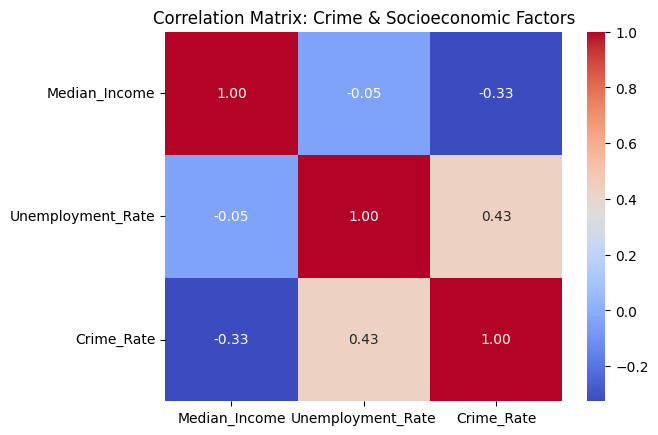

In [17]:
cols = ['Median_Income', 'Unemployment_Rate', 'Crime_Rate']

sns.heatmap(
    df_final[cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)

plt.title('Correlation Matrix: Crime & Socioeconomic Factors')
plt.show()

In [18]:
X = df_final['Unemployment_Rate']
Y = df_final['Crime_Rate']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Crime_Rate   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 16 Dec 2025   Prob (F-statistic):                nan
Time:                        11:09:32   Log-Likelihood:                    nan
No. Observations:                  51   AIC:                               nan
Df Residuals:                      49   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                    nan        na

In [19]:
df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              51 non-null     object 
 1   Median_Income      51 non-null     float64
 2   Unemployment_Rate  51 non-null     float64
 3   Crime_Rate         50 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


In [20]:
df_final[['Unemployment_Rate', 'Crime_Rate']].isna().sum()


Unemployment_Rate    0
Crime_Rate           1
dtype: int64

In [21]:
df_reg = df_final[['Unemployment_Rate', 'Crime_Rate']].dropna()

df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 50
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unemployment_Rate  50 non-null     float64
 1   Crime_Rate         50 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB


In [22]:
X = df_reg['Unemployment_Rate']
Y = df_reg['Crime_Rate']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Crime_Rate   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     10.78
Date:                Tue, 16 Dec 2025   Prob (F-statistic):            0.00192
Time:                        11:11:46   Log-Likelihood:                -312.33
No. Observations:                  50   AIC:                             628.7
Df Residuals:                      48   BIC:                             632.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                93.6334     76.29

In [24]:
df_reg2 = df_final[
    ['Crime_Rate', 'Unemployment_Rate', 'Median_Income']
].dropna()

df_reg2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 50
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Crime_Rate         50 non-null     float64
 1   Unemployment_Rate  50 non-null     float64
 2   Median_Income      50 non-null     float64
dtypes: float64(3)
memory usage: 1.6 KB


In [26]:
df_reg2['Median_Income_10k'] = df_reg2['Median_Income'] / 10000

X = df_reg2[['Unemployment_Rate', 'Median_Income_10k']]
Y = df_reg2['Crime_Rate']

X = sm.add_constant(X)

model2 = sm.OLS(Y, X).fit()

print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:             Crime_Rate   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     8.064
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           0.000975
Time:                        11:18:16   Log-Likelihood:                -310.02
No. Observations:                  50   AIC:                             626.0
Df Residuals:                      47   BIC:                             631.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               323.6549    130.57

In [27]:
df_final.to_csv('final_dashboard_data.csv', index=False)
